# Power Load Dataset & Model Performance Analysis

This notebook does three main things:

1. **Visualize the dataset** (clean + realistic):
   - Load distributions, time series samples, correlations.
2. **Visualize and test models**:
   - Load the global LightGBM model.
   - Load state residual models for states that improved.
   - Compare predictions vs actuals for selected states.
3. **Compute performance metrics**:
   - MAE, RMSE, MAPE for global and corrected (global + residual) models.
   - Per-state comparison tables and bar plots.

Use this notebook as evidence of dataset realism and model quality in your project report.

In [27]:
# 0. Imports & basic setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

MODEL_GLOBAL_PATH = r"C:\Users\DEV\Desktop\Minor Project\models\global_model.joblib"
STATE_MODELS_DIR = r"C:\Users\DEV\Desktop\Minor Project\models\state_models"
DATA_CLEAN = r"C:\Users\DEV\Desktop\Minor Project\Project\Data\synthetic_indian_load_data.csv"
DATA_REALISTIC = r"C:\Users\DEV\Desktop\Minor Project\Project\Data\synthetic_indian_load_data_realistic.csv"

TARGET_COL = "Gross_Load_MW"

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0

print("Working directory:", os.getcwd())

Working directory: c:\Users\DEV\Desktop\Minor Project\Project\Data


## 1. Load and Inspect Datasets

We load both the **clean** and **realistic** datasets to compare:
- Basic statistics
- Target distribution
- Example time series for a few states
- Correlations between load and weather/time features.

In [28]:
# 1.1 Load clean and realistic datasets
df_clean = pd.read_csv(DATA_CLEAN)
df_real = pd.read_csv(DATA_REALISTIC)

# Ensure Timestamp_UTC is datetime
df_clean["Timestamp_UTC"] = pd.to_datetime(df_clean["Timestamp_UTC"])
df_real["Timestamp_UTC"] = pd.to_datetime(df_real["Timestamp_UTC"])

print("Clean dataset shape:", df_clean.shape)
print("Realistic dataset shape:", df_real.shape)

df_clean.head()

Clean dataset shape: (316224, 10)
Realistic dataset shape: (316224, 10)


,State_Code,Timestamp_UTC,Gross_Load_MW,Hour_Of_Day,Day_Of_Week,Is_Weekend,Is_Holiday_State,Avg_Temp_C,Temp_Change_6H,Avg_Humidity_Pct
0,AN,2024-01-01 00:00:00,86.071275,0,1,0,1,26.589997,0.0,56.357856
1,AN,2024-01-01 01:00:00,84.548890,1,1,0,1,25.877382,0.0,57.219632
2,AN,2024-01-01 02:00:00,80.969990,2,1,0,1,24.176107,0.0,60.982410
3,AN,2024-01-01 03:00:00,70.767320,3,1,0,1,22.562300,0.0,47.828219
4,AN,2024-01-01 04:00:00,75.952978,4,1,0,1,22.382120,0.0,73.130531


### 1.2 Basic statistics

Compare basic statistics of key columns between clean and realistic datasets.

In [29]:
numeric_cols = [
    TARGET_COL,
    "Hour_Of_Day",
    "Day_Of_Week",
    "Avg_Temp_C",
    "Temp_Change_6H",
    "Avg_Humidity_Pct",
]

print("Clean data summary:")
display(df_clean[numeric_cols].describe())

print("Realistic data summary:")
display(df_real[numeric_cols].describe())

Clean data summary:


,Gross_Load_MW,Hour_Of_Day,Day_Of_Week,Avg_Temp_C,Temp_Change_6H,Avg_Humidity_Pct
count,316224.000000,316224.000000,316224.000000,316224.000000,316224.000000,316224.000000
mean,30294.845438,11.500000,3.986339,22.397527,0.001571,43.453117
std,37812.757900,6.922197,2.003369,11.689479,3.683282,14.310317
min,34.703612,0.000000,1.000000,-27.048577,-12.967891,20.000000
25%,2348.803944,5.750000,2.000000,14.324884,-2.831900,31.879379
50%,13965.079573,11.500000,4.000000,23.627871,0.000000,44.618782
75%,45444.828930,17.250000,6.000000,31.199953,2.830939,55.117104
max,203239.073217,23.000000,7.000000,50.971920,13.720578,85.272676


Realistic data summary:


,Gross_Load_MW,Hour_Of_Day,Day_Of_Week,Avg_Temp_C,Temp_Change_6H,Avg_Humidity_Pct
count,315276.000000,316224.000000,316224.000000,314643.000000,314643.000000,314643.000000
mean,30300.371150,11.500000,3.986339,22.398347,0.002393,43.450268
std,37832.463830,6.922197,2.003369,11.690566,3.683468,14.311589
min,25.380577,0.000000,1.000000,-27.048577,-12.967891,20.000000
25%,2348.466968,5.750000,2.000000,14.327558,-2.830615,31.873453
50%,13965.215128,11.500000,4.000000,23.628479,0.000000,44.611959
75%,45442.931579,17.250000,6.000000,31.201060,2.831980,55.116304
max,261679.849733,23.000000,7.000000,50.971920,13.720578,85.272676


### 1.3 Target distribution comparison

Visualize the distribution of `Gross_Load_MW` for clean vs realistic datasets.

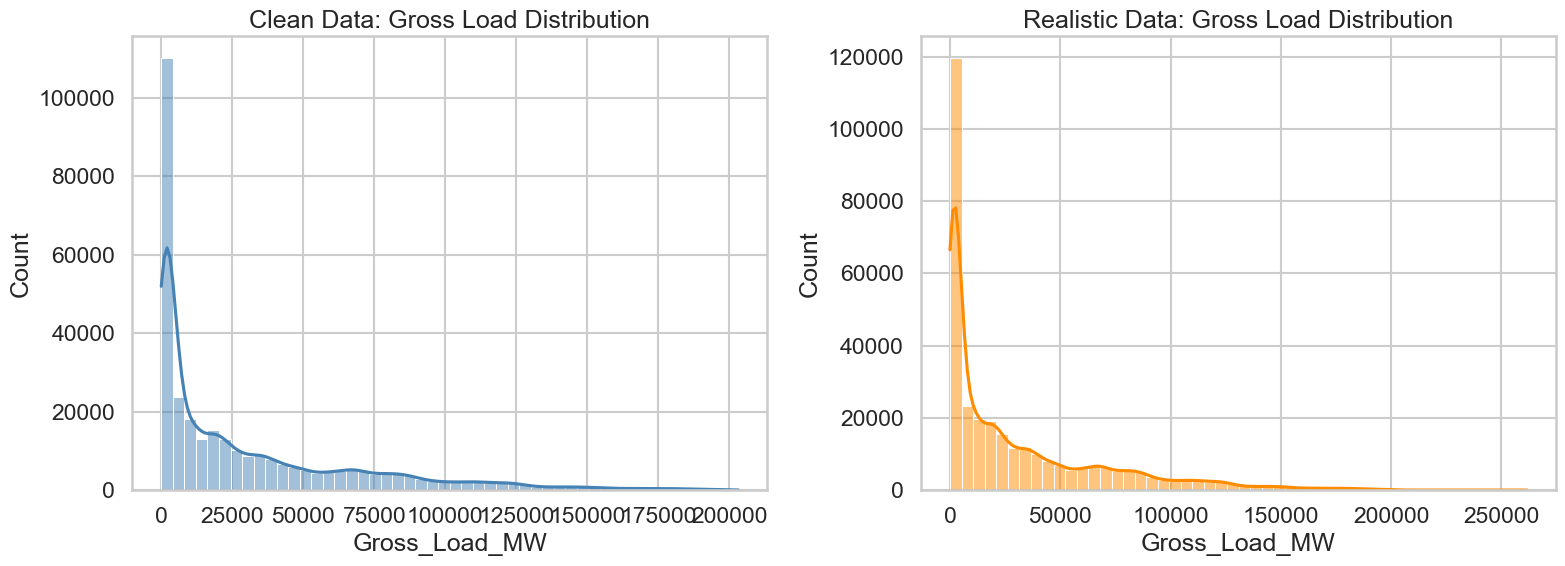

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df_clean[TARGET_COL], bins=50, kde=True, ax=ax[0], color="steelblue")
ax[0].set_title("Clean Data: Gross Load Distribution")
ax[0].set_xlabel("Gross_Load_MW")

sns.histplot(df_real[TARGET_COL].dropna(), bins=50, kde=True, ax=ax[1], color="darkorange")
ax[1].set_title("Realistic Data: Gross Load Distribution")
ax[1].set_xlabel("Gross_Load_MW")

plt.tight_layout()
plt.show()

### 1.4 Example time series for a few states

Plot a sample of time series for 3–4 states to show daily and seasonal patterns, and differences in scale between states.

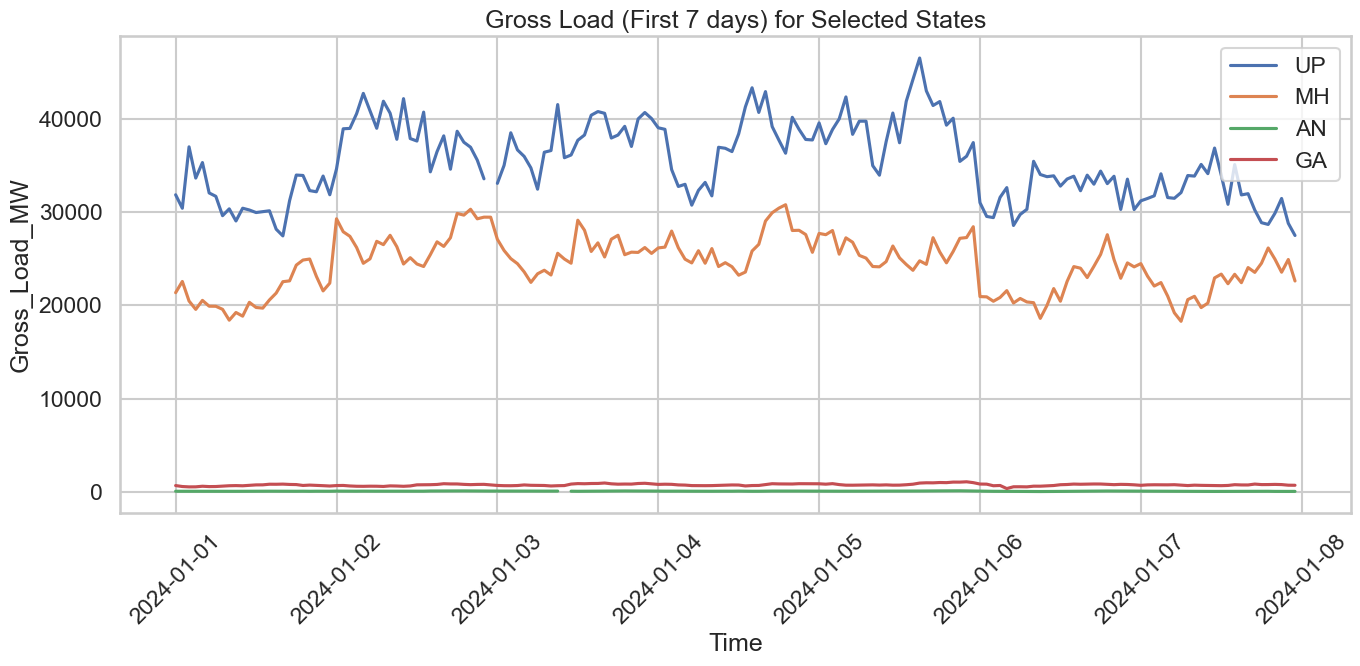

In [31]:
sample_states = ["UP", "MH", "AN", "GA"]  # choose some large and small states
days_to_plot = 7  # first week of the year

start_time = df_real["Timestamp_UTC"].min()
end_time = start_time + pd.Timedelta(days=days_to_plot)

mask = (df_real["Timestamp_UTC"] >= start_time) & (df_real["Timestamp_UTC"] < end_time)
df_sample = df_real[mask & df_real["State_Code"].isin(sample_states)].copy()

fig, ax = plt.subplots(figsize=(14, 7))
for state in sample_states:
    sub = df_sample[df_sample["State_Code"] == state]
    ax.plot(sub["Timestamp_UTC"], sub[TARGET_COL], label=state)

ax.set_title(f"Gross Load (First {days_to_plot} days) for Selected States")
ax.set_xlabel("Time")
ax.set_ylabel("Gross_Load_MW")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5 Correlation heatmap (realistic data)

Show correlations between load, temperature, humidity and calendar features to highlight expected relationships.

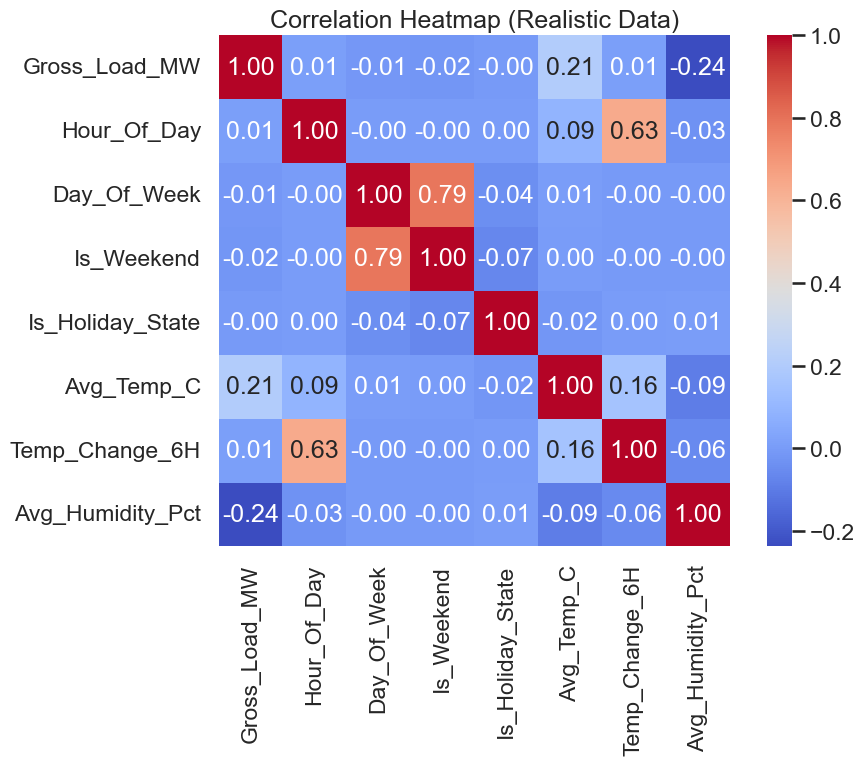

In [32]:
corr_cols = [
    TARGET_COL,
    "Hour_Of_Day",
    "Day_Of_Week",
    "Is_Weekend",
    "Is_Holiday_State",
    "Avg_Temp_C",
    "Temp_Change_6H",
    "Avg_Humidity_Pct",
]

corr = df_real[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Realistic Data)")
plt.tight_layout()
plt.show()

## 2. Load Models & Rebuild Features

We:

1. Load the **global LightGBM pipeline** (`models/global_model.joblib`).
2. Load any available **state residual models** from `models/state_models/`.
3. Recreate the same **lag & rolling features** and **time-based train/val/test split** as used during training.

This allows us to:
- Re-evaluate the models on the held-out **test set**.
- Make visual comparisons of **actual vs predicted** for specific states.
- Build summary performance tables and plots.

In [33]:
# 2.1 Load global model

assert os.path.exists(MODEL_GLOBAL_PATH), f"Global model not found at {MODEL_GLOBAL_PATH}"
global_model = joblib.load(MODEL_GLOBAL_PATH)
print("Loaded global model from", MODEL_GLOBAL_PATH)


# 2.2 Load available state residual models (if any)
state_residual_models = {}
if os.path.isdir(STATE_MODELS_DIR):
    for fname in os.listdir(STATE_MODELS_DIR):
        if fname.endswith("_residual_model.joblib"):
            state_code = fname.split("_")[1]  # state_XX_residual_model.joblib
            path = os.path.join(STATE_MODELS_DIR, fname)
            state_residual_models[state_code] = joblib.load(path)
    print("Loaded residual models for states:", sorted(state_residual_models.keys()))
else:
    print("No state residual models directory found.")

Loaded global model from C:\Users\DEV\Desktop\Minor Project\models\global_model.joblib
Loaded residual models for states: ['AN', 'GA', 'JK', 'LA', 'LD', 'MH']


In [34]:
# 2.3 Rebuild time-series features and splits, same as in training scripts
LAG_HOURS = [1, 2, 3, 24, 168]
ROLLING_WINDOWS = [3, 24, 168]
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

df = df_real.copy()
df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)
df = df.sort_values(["State_Code", "Timestamp_UTC"]).reset_index(drop=True)

group = df.groupby("State_Code")
for lag in LAG_HOURS:
    df[f"Load_lag_{lag}h"] = group[TARGET_COL].shift(lag)

for window in ROLLING_WINDOWS:
    df[f"Load_roll_mean_{window}h"] = (
        group[TARGET_COL].shift(1).rolling(window=window, min_periods=1).mean()
    )

# Drop rows with NaNs introduced by lag/rolling
df = df.dropna().reset_index(drop=True)
print("Data shape after feature engineering:", df.shape)

# Time-based split by Timestamp_UTC
df = df.sort_values("Timestamp_UTC").reset_index(drop=True)
n = len(df)
train_end = int(n * TRAIN_RATIO)
val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

train_df = df.iloc[:train_end].reset_index(drop=True)
val_df = df.iloc[train_end:val_end].reset_index(drop=True)
test_df = df.iloc[val_end:].reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Data shape after feature engineering: (307677, 18)
Train: 215373, Val: 46152, Test: 46152


In [35]:
# 2.4 Build feature matrices
def build_feature_matrices(local_df: pd.DataFrame):
    feature_cols = [
        "State_Code",
        "Hour_Of_Day",
        "Day_Of_Week",
        "Is_Weekend",
        "Is_Holiday_State",
        "Avg_Temp_C",
        "Temp_Change_6H",
        "Avg_Humidity_Pct",
    ]
    lag_roll = [c for c in local_df.columns if c.startswith("Load_lag_") or c.startswith("Load_roll_mean_")]
    feature_cols.extend(lag_roll)

    X = local_df[feature_cols].copy()
    y = local_df[TARGET_COL].copy()
    return X, y

X_train, y_train = build_feature_matrices(train_df)
X_val, y_val = build_feature_matrices(val_df)
X_test, y_test = build_feature_matrices(test_df)

print("Feature matrix shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("  X_test :", X_test.shape, "y_test :", y_test.shape)

Feature matrix shapes:
  X_train: (215373, 16) y_train: (215373,)
  X_val  : (46152, 16) y_val  : (46152,)
  X_test : (46152, 16) y_test : (46152,)


## 3. Global Model Performance Visualization

We compute metrics of the **global model** on the test set and visualize predicted vs actual load for a few states.

In [36]:
# 3.1 Global model performance metrics on test
y_test_pred_global = global_model.predict(X_test)

mae_g = mean_absolute_error(y_test, y_test_pred_global)
rmse_g = rmse(y_test, y_test_pred_global)
mape_g = mape(y_test, y_test_pred_global)

print("Global Model - Test Performance:")
print(f"  MAE  : {mae_g:.3f}")
print(f"  RMSE : {rmse_g:.3f}")
print(f"  MAPE : {mape_g:.2f}%")

c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Global Model - Test Performance:
  MAE  : 2796.774
  RMSE : 8649.109
  MAPE : 5.79%


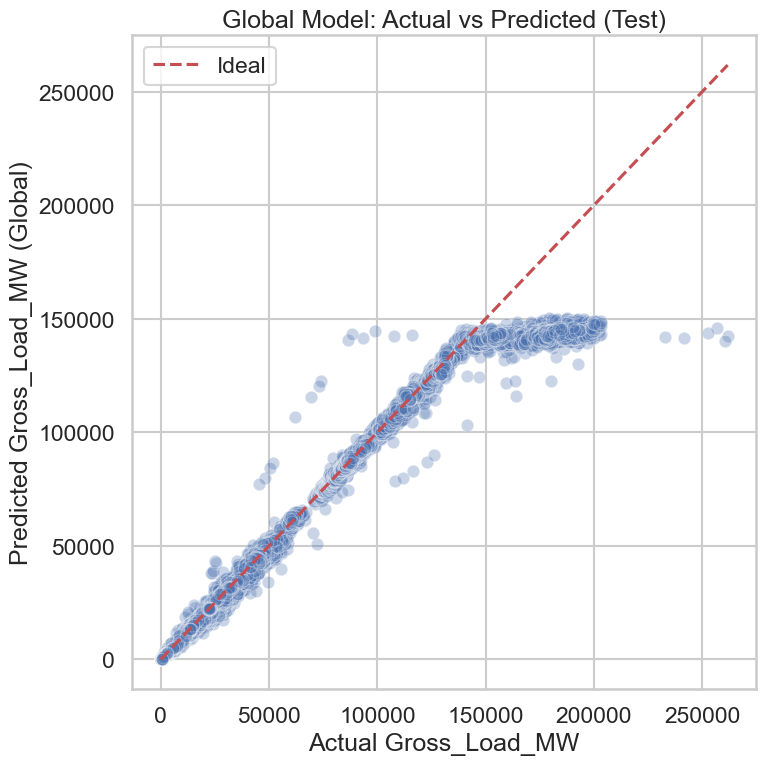

In [37]:
# 3.2 Actual vs Predicted scatter (global model, test set)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_test_pred_global, alpha=0.3)
max_val = max(y_test.max(), y_test_pred_global.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal')
plt.xlabel("Actual Gross_Load_MW")
plt.ylabel("Predicted Gross_Load_MW (Global)")
plt.title("Global Model: Actual vs Predicted (Test)")
plt.legend()
plt.tight_layout()
plt.show()

### 3.3 Time series comparison for a chosen state (global model)

Pick a state and plot the actual vs predicted load over a short test period to visually inspect fit quality.

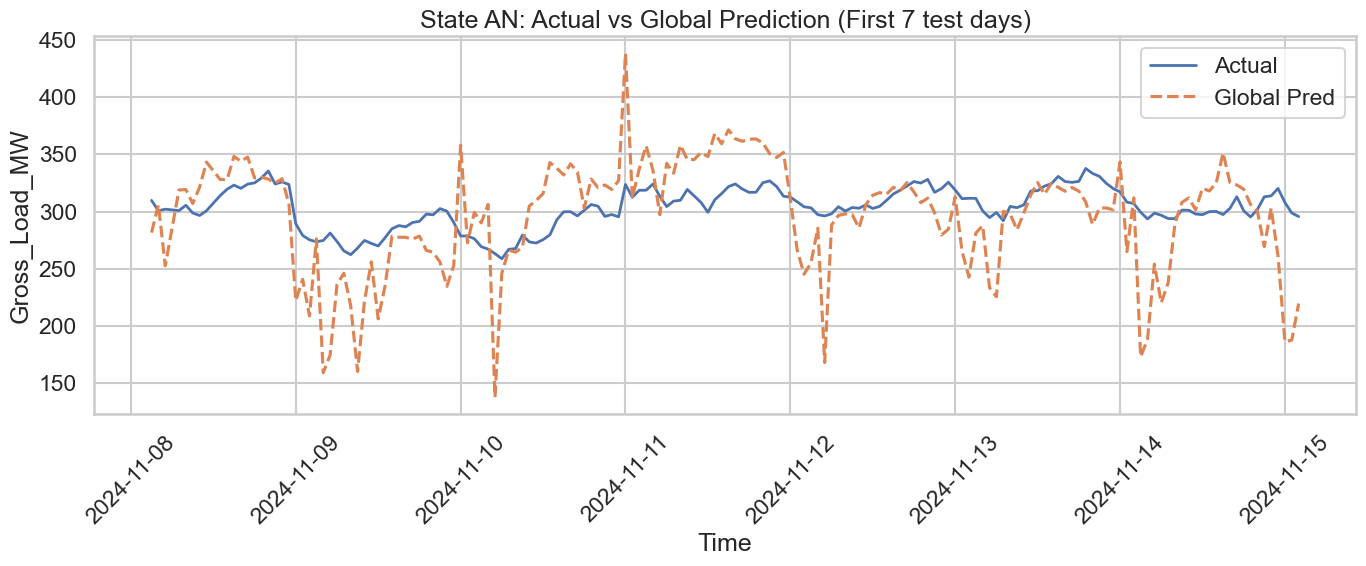

In [63]:
STATE_TO_PLOT = "AN"  # change to any state code e.g., "UP", "AN", etc.
days_to_plot = 7

test_df_global = test_df.copy()
test_df_global["y_true"] = y_test.values
test_df_global["y_pred_global"] = y_test_pred_global

state_mask = test_df_global["State_Code"] == STATE_TO_PLOT
state_test = test_df_global[state_mask].copy()
if len(state_test) == 0:
    print(f"No test data for state {STATE_TO_PLOT}")
else:
    # Take first N days in test for this state
    start_time_s = state_test["Timestamp_UTC"].min()
    end_time_s = start_time_s + pd.Timedelta(days=days_to_plot)
    mask_s = (state_test["Timestamp_UTC"] >= start_time_s) & (state_test["Timestamp_UTC"] < end_time_s)
    plot_df = state_test[mask_s]

    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["Timestamp_UTC"], plot_df["y_true"], label="Actual", linewidth=2)
    plt.plot(plot_df["Timestamp_UTC"], plot_df["y_pred_global"], label="Global Pred", linestyle="--")
    plt.title(f"State {STATE_TO_PLOT}: Actual vs Global Prediction (First {days_to_plot} test days)")
    plt.xlabel("Time")
    plt.ylabel("Gross_Load_MW")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3.3 States with personalized Models

c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


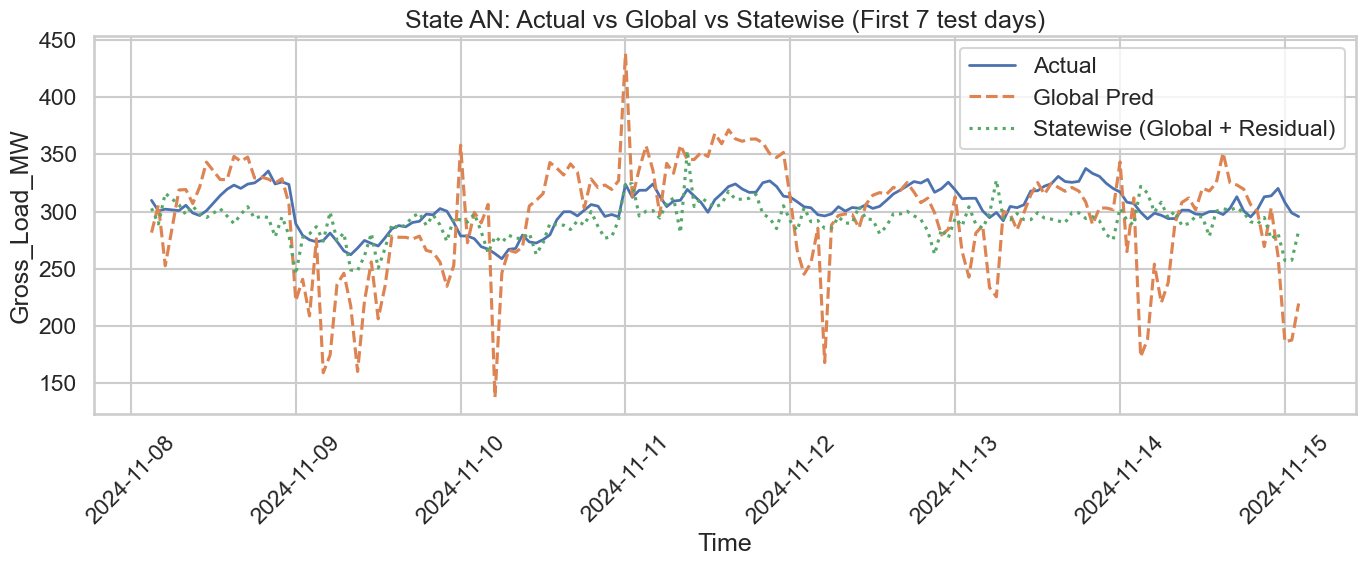

In [65]:
STATE_TO_PLOT = "AN"  # change to any state code e.g., "UP", "AN", etc.
days_to_plot = 7

# Copy test df and attach global predictions
test_df_global = test_df.copy()
test_df_global["y_true"] = y_test.values
test_df_global["y_pred_global"] = y_test_pred_global

# If a residual model exists for this state, build statewise prediction = global + residual
if STATE_TO_PLOT in state_residual_models:
    # Rebuild X_test_s and corrected predictions for this state only
    state_rows = test_df_global["State_Code"] == STATE_TO_PLOT
    state_test_for_features = test_df[state_rows].copy()  # original feature df for this state
    X_test_s, y_test_s = build_feature_matrices(state_test_for_features)

    residual_model = state_residual_models[STATE_TO_PLOT]
    y_residual_pred_s = residual_model.predict(X_test_s)
    y_statewise_s = y_test_pred_global[state_rows] + y_residual_pred_s

    # Attach back to test_df_global for plotting
    test_df_global.loc[state_rows, "y_pred_statewise"] = y_statewise_s
else:
    test_df_global["y_pred_statewise"] = np.nan  # no statewise line if model not available

# Filter for the chosen state
state_mask = test_df_global["State_Code"] == STATE_TO_PLOT
state_test = test_df_global[state_mask].copy()

if len(state_test) == 0:
    print(f"No test data for state {STATE_TO_PLOT}")
else:
    # Take first N days in test for this state
    start_time_s = state_test["Timestamp_UTC"].min()
    end_time_s = start_time_s + pd.Timedelta(days=days_to_plot)
    mask_s = (state_test["Timestamp_UTC"] >= start_time_s) & (state_test["Timestamp_UTC"] < end_time_s)
    plot_df = state_test[mask_s]

    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["Timestamp_UTC"], plot_df["y_true"], label="Actual", linewidth=2)
    plt.plot(plot_df["Timestamp_UTC"], plot_df["y_pred_global"], label="Global Pred", linestyle="--")

    # Plot statewise line only if we actually have it
    if STATE_TO_PLOT in state_residual_models:
        plt.plot(
            plot_df["Timestamp_UTC"],
            plot_df["y_pred_statewise"],
            label="Statewise (Global + Residual)",
            linestyle=":"
        )

    plt.title(f"State {STATE_TO_PLOT}: Actual vs Global vs Statewise (First {days_to_plot} test days)")
    plt.xlabel("Time")
    plt.ylabel("Gross_Load_MW")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Per-State Residual Models vs Global

For states where we have residual models (e.g., `AN, GA, JK, LA, LD, MH`),
we compare **global vs corrected (global + residual)** performance on the test set and visualize the difference.

We will:
- Compute per-state RMSE/MAE/MAPE for global and corrected.
- Build a dataframe summarizing per-state performance.
- Plot a bar chart of RMSE and MAPE before vs after correction.
- Show a time series example for one improved state.

In [39]:
# 4.1 Compute per-state metrics (global and corrected where residual model exists)
state_metrics = []

for state in sorted(df["State_Code"].unique()):
    test_s = test_df[test_df["State_Code"] == state]
    if test_s.empty:
        continue

    X_test_s, y_test_s = build_feature_matrices(test_s)
    y_pred_g_s = global_model.predict(X_test_s)

    mae_g_s = mean_absolute_error(y_test_s, y_pred_g_s)
    rmse_g_s = rmse(y_test_s, y_pred_g_s)
    mape_g_s = mape(y_test_s, y_pred_g_s)

    entry = {
        "State_Code": state,
        "MAE_Global": mae_g_s,
        "RMSE_Global": rmse_g_s,
        "MAPE_Global": mape_g_s,
        "MAE_Corrected": np.nan,
        "RMSE_Corrected": np.nan,
        "MAPE_Corrected": np.nan,
    }

    # If residual model exists, compute corrected predictions
    if state in state_residual_models:
        residual_model = state_residual_models[state]
        y_residual_pred = residual_model.predict(X_test_s)
        y_corrected = y_pred_g_s + y_residual_pred

        entry["MAE_Corrected"] = mean_absolute_error(y_test_s, y_corrected)
        entry["RMSE_Corrected"] = rmse(y_test_s, y_corrected)
        entry["MAPE_Corrected"] = mape(y_test_s, y_corrected)

    state_metrics.append(entry)

metrics_df = pd.DataFrame(state_metrics).sort_values("State_Code").reset_index(drop=True)
metrics_df.head(10)

c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X 

,State_Code,MAE_Global,RMSE_Global,MAPE_Global,MAE_Corrected,RMSE_Corrected,MAPE_Corrected
0,AN,31.883518,42.154155,10.215920,25.589498,30.169069,7.914987
1,AP,1029.218255,2110.004783,1.191646,NaN,NaN,NaN
2,AR,1481.545074,1774.785365,13.103593,NaN,NaN,NaN
3,AS,323.597751,453.428130,2.688050,NaN,NaN,NaN
4,BH,700.372433,893.175497,0.842024,NaN,NaN,NaN
5,CH,546.319457,697.392787,11.948953,NaN,NaN,NaN
6,CHH,897.598394,1239.456519,2.998818,NaN,NaN,NaN
7,DL,1192.372816,1524.062731,1.446680,NaN,NaN,NaN
8,DNHD,51.494129,65.791389,6.339235,NaN,NaN,NaN
9,GA,295.211132,351.578837,6.094410,200.330847,273.496320,4.114483


### 4.1 Compute per-state metrics


In [52]:
# EXTRA: Classification-style metrics (accuracy, precision, recall, F1) per state
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classification_rows = []

# We reuse test_df, X_test, y_test, global_model built earlier
# Build a helper to get per-state X_test and y_test easily
def get_state_test_data(state_code: str):
    test_s = test_df[test_df["State_Code"] == state_code]
    if test_s.empty:
        return None, None, None
    X_test_s, y_test_s = build_feature_matrices(test_s)
    return test_s, X_test_s, y_test_s

states_all = sorted(df["State_Code"].unique())

for state in states_all:
    test_s, X_test_s, y_test_s = get_state_test_data(state)
    if test_s is None:
        continue

    # Global model predictions for this state
    y_pred_g_s = global_model.predict(X_test_s)

    # Define a binary classification threshold for "high load"
    # Here we use median of the TRUE test loads for this state
    threshold = float(np.median(y_test_s))

    # Binarize: 1 = high load, 0 = low/normal load
    y_true_bin = (y_test_s >= threshold).astype(int)
    y_pred_bin = (y_pred_g_s >= threshold).astype(int)

    # Compute classification metrics
    acc = accuracy_score(y_true_bin, y_pred_bin)
    prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    classification_rows.append({
        "State_Code": state,
        "Threshold_Median_Load": threshold,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
    })

classification_metrics_df = pd.DataFrame(classification_rows).sort_values("State_Code").reset_index(drop=True)

print("Classification-style metrics per state (based on median-load threshold):")
display(classification_metrics_df)

c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X 

Classification-style metrics per state (based on median-load threshold):


c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,State_Code,Threshold_Median_Load,Accuracy,Precision,Recall,F1_Score
0,AN,318.805468,0.652854,0.675000,0.590625,0.630000
1,AP,86747.898149,0.913820,0.947899,0.875776,0.910412
2,AR,10829.104283,0.845192,0.968220,0.714063,0.821942
3,AS,12001.199355,0.830469,0.920477,0.723437,0.810149
4,BH,83308.735697,0.947779,0.934947,0.962617,0.948580
5,CH,4129.853091,0.867866,0.968191,0.760938,0.852143
6,CHH,29039.299771,0.854814,0.959759,0.740683,0.836109
7,DL,81506.083590,0.950666,0.969055,0.931142,0.949721
8,DNHD,855.124319,0.870791,0.865741,0.877934,0.871795
9,GA,4913.570037,0.726917,0.980132,0.463224,0.629118


### 4.2 Show states where corrected models exist and improved

Filter only states with corrected metrics (non-NaN) and compute relative improvement in RMSE and MAPE.

In [49]:
improved_states_df = metrics_df.dropna(subset=["RMSE_Corrected"]).copy()
improved_states_df["RMSE_Improvement_%"] = (
    (improved_states_df["RMSE_Global"] - improved_states_df["RMSE_Corrected"]) 
    / improved_states_df["RMSE_Global"] * 100
)
improved_states_df["MAPE_Improvement_%"] = (
    (improved_states_df["MAPE_Global"] - improved_states_df["MAPE_Corrected"]) 
    / improved_states_df["MAPE_Global"] * 100
)

print("States with residual models (and their improvements):")
display(improved_states_df[[
    "State_Code", "RMSE_Global", "RMSE_Corrected", "RMSE_Improvement_%",
    "MAPE_Global", "MAPE_Corrected", "MAPE_Improvement_%"
]].sort_values("RMSE_Improvement_%", ascending=False))

States with residual models (and their improvements):


,State_Code,RMSE_Global,RMSE_Corrected,RMSE_Improvement_%,MAPE_Global,MAPE_Corrected,MAPE_Improvement_%
14,JK,1135.425025,712.785128,37.223056,8.232869,5.109335,37.939804
17,LA,2884.696922,1928.415001,33.150170,7.382659,4.746848,35.702737
0,AN,42.154155,30.169069,28.431565,10.215920,7.914987,22.523015
18,LD,52.885912,40.579858,23.269059,12.050397,10.277124,14.715475
9,GA,351.578837,273.496320,22.209106,6.094410,4.114483,32.487590
19,MH,41217.697858,38058.174698,7.665453,21.690377,19.922235,8.151733


### 4.3 Bar plot of RMSE before vs after correction (for improved states)

Visually compare RMSE values for states where residual models are available.

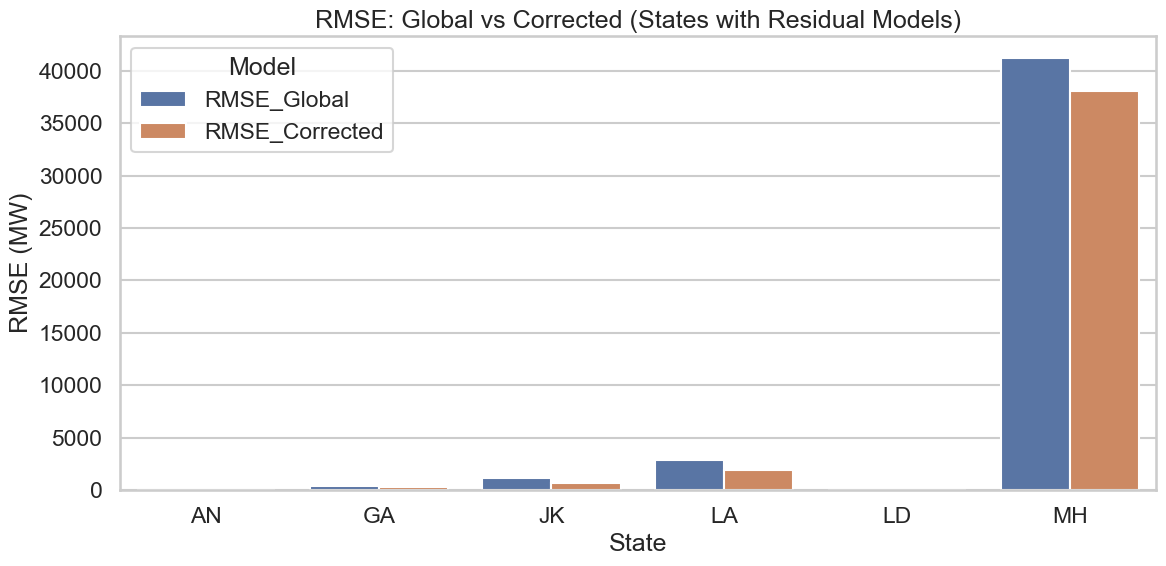

In [50]:
if not improved_states_df.empty:
    melted = improved_states_df.melt(
        id_vars=["State_Code"],
        value_vars=["RMSE_Global", "RMSE_Corrected"],
        var_name="Model",
        value_name="RMSE"
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(x="State_Code", y="RMSE", hue="Model", data=melted)
    plt.title("RMSE: Global vs Corrected (States with Residual Models)")
    plt.xlabel("State")
    plt.ylabel("RMSE (MW)")
    plt.tight_layout()
    plt.show()
else:
    print("No states with residual models to plot.")

### 4.4 Time series visualization for a state with improvement

Pick one improved state (e.g. `JK` or `LA`) and compare:
- Actual
- Global prediction
- Corrected prediction (global + residual)
over a sample period in the test set.

Plotting detailed comparison for improved state: JK


c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\DEV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


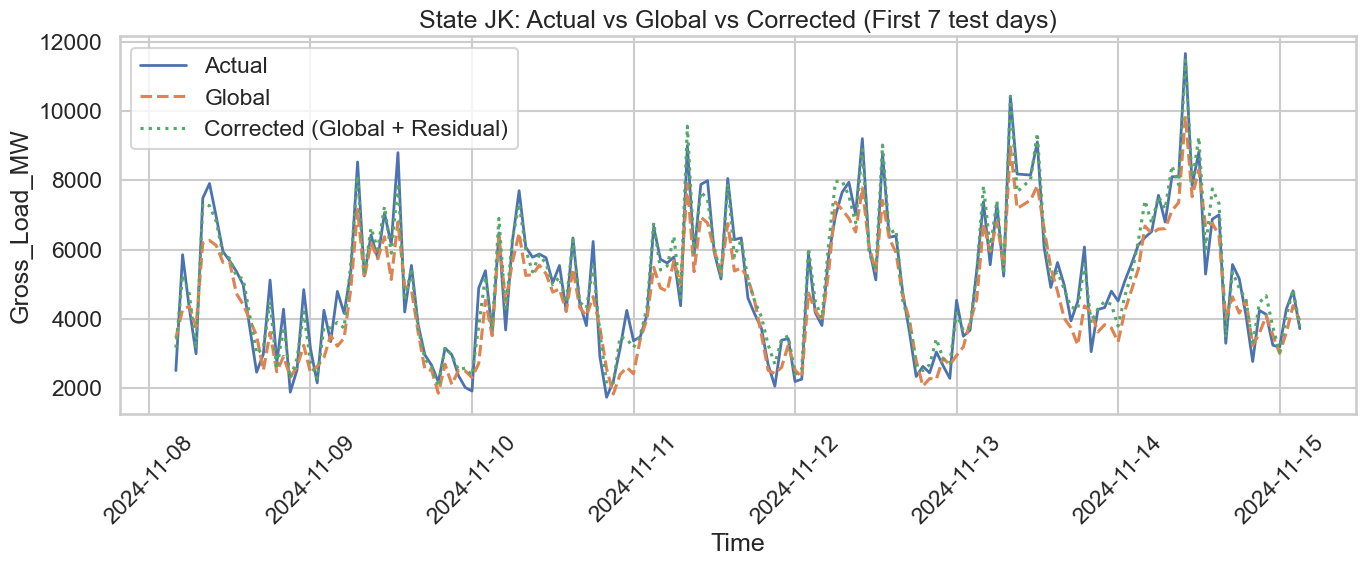

In [51]:
# Choose a state that has a residual model and positive improvement
if not improved_states_df.empty:
    STATE_IMPROVED = improved_states_df.sort_values("RMSE_Improvement_%", ascending=False)["State_Code"].iloc[0]
    print("Plotting detailed comparison for improved state:", STATE_IMPROVED)

    test_s = test_df[test_df["State_Code"] == STATE_IMPROVED].copy()
    X_test_s, y_test_s = build_feature_matrices(test_s)

    y_pred_g_s = global_model.predict(X_test_s)
    residual_model = state_residual_models[STATE_IMPROVED]
    y_residual_pred_s = residual_model.predict(X_test_s)
    y_corrected_s = y_pred_g_s + y_residual_pred_s

    test_s["Actual"] = y_test_s.values
    test_s["Global"] = y_pred_g_s
    test_s["Corrected"] = y_corrected_s

    # Plot only first N days of test
    days_to_plot = 7
    start_time_s = test_s["Timestamp_UTC"].min()
    end_time_s = start_time_s + pd.Timedelta(days=days_to_plot)
    mask_s = (test_s["Timestamp_UTC"] >= start_time_s) & (test_s["Timestamp_UTC"] < end_time_s)
    plot_df = test_s[mask_s]

    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["Timestamp_UTC"], plot_df["Actual"], label="Actual", linewidth=2)
    plt.plot(plot_df["Timestamp_UTC"], plot_df["Global"], label="Global", linestyle="--")
    plt.plot(plot_df["Timestamp_UTC"], plot_df["Corrected"], label="Corrected (Global + Residual)", linestyle=":")
    plt.title(f"State {STATE_IMPROVED}: Actual vs Global vs Corrected (First {days_to_plot} test days)")
    plt.xlabel("Time")
    plt.ylabel("Gross_Load_MW")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No improved states available for detailed plot.")

## 5. Summary & Conclusions

From this notebook you can extract:

1. **Dataset nature**:
   - Distributions of load and weather.
   - Time series patterns by state.
   - Correlations between variables.

2. **Model performance**:
   - Global model metrics on test set (MAE, RMSE, MAPE).
   - Per-state metrics with and without residual correction.
   - Visual evidence (scatter plots and time series) that the model follows the actual load closely.

3. **Per-state improvements**:
   - Some specific states (e.g., AN, GA, JK, LA, LD, MH) show **significant RMSE/MAPE improvements** when adding residual models on top of the global baseline.

You can now use these plots and tables in your report/PowerPoint to demonstrate:

- The **realism and complexity** of your synthetic dataset.
- The **strength** of your global forecasting model.
- The **benefit** of per-state fine-tuning where it actually improves accuracy.

If you want, you can duplicate some cells and focus them on specific key states (e.g., UP, MH, TN) for deeper discussion.